# Natural Language Processing - Yelp Review Analysis

This notebook uses a small subset of the data from Kaggle's [Yelp Business Rating Prediction](https://www.kaggle.com/c/yelp-recsys-2013) competition.

**Description of the data:**

- **`yelp.csv`** contains the dataset. It is stored in the repository (in the **`data`** directory), so there is no need to download anything from the Kaggle website.
- Each observation (row) in this dataset is a review of a particular business by a particular user.
- The **stars** column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.
- The **text** column is the text of the review.

**Goal:** Predict the star rating of a review using **only** the review text.

## Libraries

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sys  

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import preprocessing

%matplotlib inline
sns.set(color_codes=True)

# ASCII errors in yelp docs.
reload(sys)  
sys.setdefaultencoding('utf8')

## Loading the data

In [2]:
path = '../data/yelp.csv'
df = pd.read_csv(path)

## Exploration

In [3]:
df.shape

(10000, 10)

In [4]:
df.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0


There are 10 variables and 10,000 observations.

The variables can be categorized into two types:

identifier: 
- **business_id**
- **date**
- **review_id**
- **type**
- **user_id**

qualitative:
- **stars**
- **cool**
- **useful**
- **funny **
- **text**

### Ordinal variables

In [5]:
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


### Stars

The most important variable here, and what will be the response for training the model, is **stars**.

In [6]:
# Aggregate df by stars and get the count.
stars_count = df.groupby('stars').stars.count()
stars_count

stars
1         749
2         927
3        1461
4        3526
5        3337
Name: stars, dtype: int64

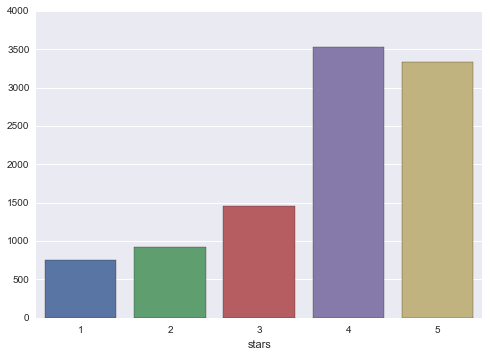

In [7]:
sns.barplot(stars_count.index, stars_count.values)

As shown above, the vast majority reviews have a high rating of 4 or 5 stars. 

###Who reviews the reviewers?

After a user submits their star rating and written review for a restaurant, other readers who read the review have the option of labelling the review as funny, cool and useful. This goes against the normal "like/unlike" paradigm in order to encourage readers to write more interesting and detailed reviews. However, most reviews receive very little input from other users as shown in the figures below.

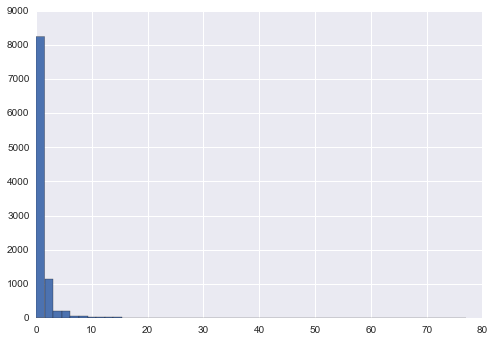

In [8]:
df.cool.hist(bins=50)

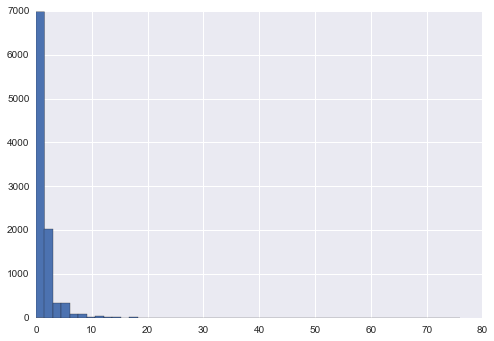

In [9]:
df.useful.hist(bins=50)

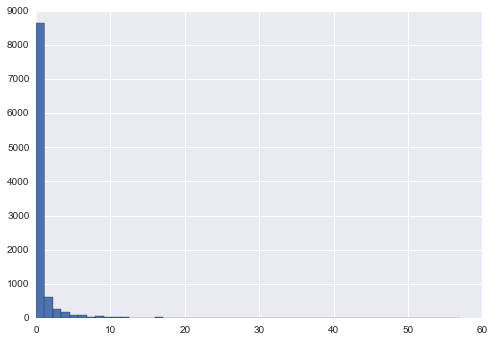

In [10]:
df.funny.hist(bins=50)

The goal of this project is to predict stars rating based on the text so these variables aren't very relevant and will not be considered for the model.

Finally, for the sake of simplicity this analysis will only use 1 star and 5 star reviews.

In [11]:
# filter the DataFrame using an OR condition
df = df[(df.stars==5) | (df.stars==1)]

## Splitting the data


In [12]:
# Feature and response.
X = df.text
y = df.stars

In [13]:
# Check that y contains 5 different classes.
y.value_counts().sort_index()

1     749
5    3337
dtype: int64

In [14]:
# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [15]:
# Instantiate CountVectorizer.
vect = CountVectorizer()

In [16]:
# Fit and transform X_train into X_train_dtm.
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape

(3064, 16825)

In [17]:
# Transform X_test into X_test_dtm
X_test_dtm = vect.transform(X_test)
X_test_dtm.shape

(1022, 16825)

### Model creation and prediction

In [18]:
# Instantiate MultinomialNB.
nb = MultinomialNB()

# Train the model using X_train_dtm.
nb.fit(X_train_dtm, y_train)

# Make class predictions for X_test_dtm.
y_pred_class = nb.predict(X_test_dtm)

# Accuracy

In [19]:
# Calculate accuracy of class predictions.
metrics.accuracy_score(y_test, y_pred_class)

0.91878669275929548

In [20]:
# Confusion matrix.
metrics.confusion_matrix(y_test, y_pred_class)

array([[126,  58],
       [ 25, 813]])

An accuracy of 91.88% was achieved from the model. However to properly judge this metric the null accuracy needs to be considered. The null accuracy is when a model chooses the most common class for each prediction and is the baseline for comparison. Class 5 is the most common class here with 3337 instances. 

In [21]:
y.value_counts()

5    3337
1     749
dtype: int64

In [22]:
# Null accuracy %.
(y.value_counts()[5] * 100.0)/y.shape[0]

81.669114047968677

In [23]:
# Print the confusion matrix.
metrics.confusion_matrix(y_test, y_pred_class)

array([[126,  58],
       [ 25, 813]])

The model is much more likely to make a false negative (1 star rating incorrectly predicted as 5 star) than a false positive (5 star rating incorrectly predicted as 1 star). This can be quantified using **precision**.

In [24]:
# Print the classification report.
print(metrics.classification_report(y_test, y_pred_class))

- **Precision** answers the question: "When a given class is predicted, how often are those predictions correct?"

- **Recall** answers the question: "When a given class is the true class, how often is that class predicted?" 

- **F1 score** is a weighted average of precision and recall.

- **Support** answers the question: "How many observations exist for which a given class is the true class?"

- Class 1 has low recall, meaning that the model has a hard time detecting the 1-star reviews, but high precision, meaning that when the model predicts a review is 1-star, it's usually correct.
- Class 5 has very high recall and precision, probably because 5-star reviews have polarized language, and because the model has a lot of observations to learn from.

# Examples of misclassification

In [25]:
# Example of a 5 star rating incorrectly predicted as 1 star by the model.
false_positives = (y_test == 5) & (y_pred_class == 1)
X_test[false_positives][0]

"I now consider myself an Arizonian. If you drive a lot on the 101 or 51 like I do, you'll get your fair share of chips on your windshield. You'll also have to replace a windshield like I had to do just recently. Apparently, chips and cracking windshields  is common in Arizona. In fact, I seem to recall my insurance agent telling me that insurance companies must provide this coverage in Arizona.\r\n\r\nI had a chip repaired about a year ago near the very bottom of the windshield. Just recently a small, very fine crack started traveling north on the windshield from the repaired chip (a different vendor repaired the chip). I called these guys over to my house and they said it was too long to fix, so they replaced the whole windshield the next day.\r\n\r\nWhat great service, they come out to your residence or place of business to repair or replace your windshield."

While this review is definitely overall very positive, it's easy to see where a model can get tripped up. For example, words like "overdue" and "shockingly" are usually extremely negative. In this case, these words are used to describe things other than the service in question; this is something that could be factored into the model. For example the word "shockingly" is wrapped in quotation marks in the text. The model could discount this feature as it could indicate sarcasm, or it could be referencing another service. 

In [26]:
# Example of a 1 star rating incorrectly predicted as 5 star by the model.
false_negatives = (y_test == 1) & (y_pred_class == 5)
X_test[false_negatives][0]

'This has to be the worst restaurant in terms of hygiene. Two of my friends had food -poisoning after having dinner here. The food is just unhealthy with tons of oil floating on the top of curries, and I am not sure if any health/hygiene code is followed here. \r\nThe service is poor and the information on its website is incorrect, the owner does not allow dine-in after 9 or 10 even though it says that the restaurant is open till 11. \r\n\r\nOne night I saw the owner cleaning the place without gloves and she was nice enough to give us a to-go parcel without cleaning her hands (great example to the servers!). I had a peek inside the kitchen when the door was ajar, and it definitely looked dirty.\r\n\r\nI have been a lot of hole-in-the-wall places around this restaurant, including Haji Baba, the Vietnamese place and others, but neither any of my friends nor I have fallen sick coz of the food. If you need a spicy-food fix, i strongly recommend you do not try this place, lest you want a vi

The model suffers from the same problem here. The reviewer blatently states that the service is 0 stars, but then references another service and showers that with praise. The model can't distinguish the subject of each sentiment and naiively predicts the rating incorrectly.

Looking at these reviews it's clear why a false positive is more common than a false positive. A rating of 1 star will sometimes mention a superior service ("don't go to A, B down the road is much better!") whereas a 5 star rating will generally only discuss the service in question ("A is amazing").

### Classification probabilities

It's also possible to see how strong a model's prediciton is. Lets see how strongly the model classified the above examples.

In [27]:
# False positive example.
nb.predict_proba(X_test_dtm)[false_positives][0]

array([ 0.99525708,  0.00474292])

In [28]:
# False negative example.
nb.predict_proba(X_test_dtm)[false_negatives][0]

array([ 0.03410551,  0.96589449])

Despite the mix of positive and negative terms in both of the above examples, the model decisively predicted the classes incorrectly.

In [29]:
# Calculate predicted probabilities for X_test_dtm.
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([  1.00000000e+00,   9.99759874e-01,   1.00000000e+00, ...,
         1.00000000e+00,   1.05200807e-19,   9.99915316e-01])

# Calculating the tokens most predictive of a 5 star review

In [30]:
# Store the vocabulary of X_train.
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

16825

In [31]:
# The model's first row is one-star reviews, second row is five-star reviews
nb.feature_count_.shape

(2L, 16825L)

In [32]:
nb.feature_count_

array([[ 26.,   4.,   1., ...,   0.,   0.,   0.],
       [ 39.,   5.,   0., ...,   1.,   1.,   1.]])

In [33]:
# Store the number of times each token appears across each class.
one_star_token_count = nb.feature_count_[0, :]
five_star_token_count = nb.feature_count_[1, :]

In [34]:
# Create a df of tokens with their separate one-star and five-star counts.
df_tokens = pd.DataFrame({'token':X_train_tokens, 'one_star_token_count':one_star_token_count, 
                       'five_star_token_count':five_star_token_count}).set_index('token')

In [35]:
#df['total_count'] = df.five_star_token_count + df.one_star_token_count 

In [36]:
# Add 1 to one-star and five-star counts to avoid dividing by 0.
df_tokens['one_star_token_count'] = df_tokens.one_star_token_count + 1
df_tokens['five_star_token_count'] = df_tokens.five_star_token_count + 1

In [37]:
df_tokens['total_count'] = df_tokens.five_star_token_count + df_tokens.one_star_token_count 

In [38]:
# first number is one-star reviews, second number is five-star reviews
nb.class_count_

array([  565.,  2499.])

In [39]:
# convert the one-star and five-star counts into frequencies
df_tokens['one_star_freq'] = df_tokens.one_star_token_count / nb.class_count_[0]
df_tokens['five_star_freq'] = df_tokens.five_star_token_count / nb.class_count_[1]

In [40]:
# calculate the ratio of five-star to one-star for each token
#df['ratio'] = df.five_star_token_count / df.one_star_token_count
df_tokens['ratio'] = df_tokens.five_star_token_count / df_tokens.one_star_token_count

In [41]:
#df['ratio'] = df.ratio.apply(lambda x: math.log(x))

In [42]:
list(df.columns.values)

['business_id',
 'date',
 'review_id',
 'stars',
 'text',
 'type',
 'user_id',
 'cool',
 'useful',
 'funny']

In [43]:
df_tokens = df_tokens[['one_star_token_count',
 'five_star_token_count',
 'total_count',
 'one_star_freq',
 'five_star_freq',
 'ratio']]

In [44]:
df_tokens.head(3)

,one_star_token_count,five_star_token_count,total_count,one_star_freq,five_star_freq,ratio
token,,,,,,
00,27,40,67,0.047788,0.016006,1.481481
000,5,6,11,0.008850,0.002401,1.200000
00a,2,1,3,0.003540,0.000400,0.500000


In [45]:
# Sort the DataFrame by five_star_ratio (descending order), and examine the first 10 rows.
df_tokens.sort('ratio', ascending=False).head(5)

,one_star_token_count,five_star_token_count,total_count,one_star_freq,five_star_freq,ratio
token,,,,,,
fantastic,2,193,195,0.003540,0.077231,96.500000
perfect,3,245,248,0.005310,0.098039,81.666667
yum,1,62,63,0.001770,0.024810,62.000000
favorite,7,345,352,0.012389,0.138055,49.285714
outstanding,1,49,50,0.001770,0.019608,49.000000


In [46]:
# Sort the DataFrame by five_star_ratio (ascending order), and examine the first 10 rows
df_tokens.sort('ratio', ascending=True).head(5)

,one_star_token_count,five_star_token_count,total_count,one_star_freq,five_star_freq,ratio
token,,,,,,
staffperson,17,1,18,0.030088,0.0004,0.058824
refused,14,1,15,0.024779,0.0004,0.071429
disgusting,24,2,26,0.042478,0.0008,0.083333
filthy,11,1,12,0.019469,0.0004,0.090909
unprofessional,9,1,10,0.015929,0.0004,0.111111


In [47]:
# Sort the DataFrame by five_star_ratio (ascending order), and examine the first 10 rows
df_tokens.sort('total_count', ascending=False).head(10)

,one_star_token_count,five_star_token_count,total_count,one_star_freq,five_star_freq,ratio
token,,,,,,
the,4176,14009,18185,7.391150,5.605842,3.354646
and,2660,10430,13090,4.707965,4.173669,3.921053
to,2410,6334,8744,4.265487,2.534614,2.628216
of,1295,4558,5853,2.292035,1.823930,3.519691
it,1329,4260,5589,2.352212,1.704682,3.205418
is,771,4391,5162,1.364602,1.757103,5.695201
was,1485,3535,5020,2.628319,1.414566,2.380471
in,942,3487,4429,1.667257,1.395358,3.701699
for,971,3316,4287,1.718584,1.326931,3.415036


In [48]:
df_tokens.describe()

,one_star_token_count,five_star_token_count,total_count,one_star_freq,five_star_freq,ratio
count,16825.000000,16825.000000,16825.000000,16825.000000,16825.000000,16825.000000
mean,5.863655,17.071204,22.934859,0.010378,0.006831,2.749364
std,54.511846,181.599432,235.073652,0.096481,0.072669,3.051345
min,1.000000,1.000000,3.000000,0.001770,0.000400,0.058824
25%,1.000000,2.000000,3.000000,0.001770,0.000800,1.500000
50%,1.000000,2.000000,4.000000,0.001770,0.000800,2.000000
75%,2.000000,5.000000,7.000000,0.003540,0.002001,3.000000
max,4176.000000,14009.000000,18185.000000,7.391150,5.605842,96.500000


In [49]:
df_tokens.head(3)

,one_star_token_count,five_star_token_count,total_count,one_star_freq,five_star_freq,ratio
token,,,,,,
00,27,40,67,0.047788,0.016006,1.481481
000,5,6,11,0.008850,0.002401,1.200000
00a,2,1,3,0.003540,0.000400,0.500000


# Visualization

In [51]:
df_tokens.head(3)

,one_star_token_count,five_star_token_count,total_count,one_star_freq,five_star_freq,ratio
token,,,,,,
00,27,40,67,0.047788,0.016006,1.481481
000,5,6,11,0.008850,0.002401,1.200000
00a,2,1,3,0.003540,0.000400,0.500000


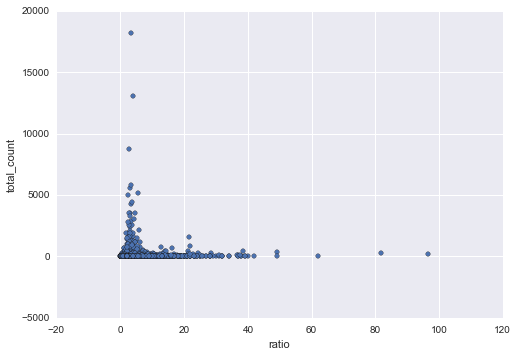

In [52]:
df_tokens.plot(kind='scatter', x='ratio', y='total_count')

# Export the data

In [53]:
df_tokens = df_tokens[['total_count', 'ratio']]

df_tokens.head(3)

,total_count,ratio
token,,
00,67,1.481481
000,11,1.200000
00a,3,0.500000


In [54]:
df_tokens.to_csv('../data/viz_data.csv')

# Ideas

http://ucb-205-keyword-demo.s3-website-us-west-2.amazonaws.com/#serves

http://people.ischool.berkeley.edu/~sayantan.satpati/yelp/#portfolioModal1
